In [5]:
# add averaging for small curves. Bigger curves may not work. We have to take our own test data from iphone camera to test

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline


In [22]:
#refactor this crap

def slope(x1,x2,y1,y2):
    return (y2-y1)/(x2-x1)

def dist(x1,x2,y1,y2):
    return math.sqrt(math.pow((x2-x1),2)+math.pow((y2-y1),2))

def yintercept(x1,x2,y1,y2):
    m = (y2-y1)/(x2-x1)
    b = y1-m*x1
    return b

def longestLine(list):
    '''
    input numRight or numLeft, list of tuples containing slopes, dist, x1,x2,y1,y2
    return tuple with largest distance. use this to interpolate to bottom of image
    or should we average all the x and y points and interpolate the average?
    '''
    longestDist = list[0][2]
    longestTuple=list[0]
    for tuple in list:
        if tuple[2] > longestDist:
            longestDist = tuple[2]
            longestTuple = tuple
    #print ("longestDist:",longestDist)
    return longestTuple
    

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255     
    #filling pixels inside the polygon defined by "vertices" with the fill color
    #this makes a black background which won't show your drawn lines
    #change the background to white or change the line color to white
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def calc_vanishing_point(lines):
    '''
    calculate vanishiing point
    y=mx+b for both left and right lines
    bleft = yleft -mleft*xleft. Use the tuplepoints for x,y
    bright = yright -mright*xright. Use the tuplepoints for x,y
    
    equations foe lrft/right lane lines
    
    yleft=mleft*xleft+bleft
    yright=mright*xright+bright
    
    bleft = yleft - mleft*xleft
    bright = yright - mright*xright

    the vanishing point is when yleft=yright=yvp and yright=xright=xvp

    y_vp=mleft*x_vp+bleft
    y_vp=mright*x_vp+bright
    
    mleft*x_vp+bleft = mright*x_vp+bright
    mleft*x_vp - mright*x_vp = bright - bleft
    x_vp(mleft - mright) = bright - bleft
    
    x_vp = (bright - bleft)/(mleft - mright)
    y_vp = mright* x_vp + bright
    
    
    take a point from the longest segment as a first approximation
    and get values for b_left and b_right. Then calculate vanishing point from 
    avgSlope and the point from the longest segment. Draw a line from the vanishing point
    and (x,540) which is the bottom of the image and where the lane line intersects the image bottom
    '''


def draw_lines(img, lines, numLeft_lastFrame,numRight_lastFrame,color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below 
    
    this calcuates the vp from the longest line segment. The problem is it doesn't use the other line segments
    and the problem is this method is dependent on the accuracy of the ROI. 
    
    ex: how to detect a curve? does the avgSlope change dramatically? 
    
    """
    numRight=[]
    numLeft=[]
    y_height = img.shape[0]
    x_width  = img.shape[1]
    
    print ("y_height", y_height," x_width:",x_width)
    
    for line in lines:
         for x1,y1,x2,y2 in line:
                m = slope(x1,x2,y1,y2)
                d = dist(x1,x2,y1,y2)
                if m > 0.5 and m < 0.8:
                    numRight.append(((x1,x2,y1,y2),m,d))
                elif m < -0.5 and m > -0.8 :
                    numLeft.append(((x1,x2,y1,y2),m,d))
       
    #  for r in numRight:
    #      print ("tuple:",r[0]," numRight slope:",r[1]," dist:", r[2])
    #  for l in numLeft:
    #      print("tuple:",l[0],"numLeft slope:",l[1], " dist:",l[2])
    #problem if first frame has no edges after hough
    if len(numRight) == 0:
        numRight = numRight_lastFrame
    if len(numLeft) == 0:
        numLeft = numLeft_lastFrame
    
    tupleRight = longestLine(numRight)
    tupleLeft = longestLine(numLeft)
    m_right = tupleRight[1]
    m_left = tupleLeft[1]
    #print ("x,y points longest line tupleRight",tupleRight," m_right:", m_right)
    #print ("x,y points longest line tupleLeft",tupleLeft," m_left:", m_left)
    
    
    xleft = int((y_height-(tupleLeft[0][2]-m_left*tupleLeft[0][0]))/m_left)   
    xright = int((y_height-(tupleRight[0][2]-m_right*tupleRight[0][0]))/m_right)
    
    b_left = tupleLeft[0][2] -m_left * tupleLeft[0][0]
    b_right = tupleRight[0][2] -m_right * tupleRight[0][0]
    
    #print("xleft:",xleft," xright:",xright," b_left:",b_left," b_right:",b_right)
    
    x_vp = int((b_right - b_left)/(m_left - m_right))
    y_vp = int(m_right * ((b_right-b_left)/(m_left-m_right)) + b_right)
    
    #print ("x_vp:", x_vp, " y_vp:",y_vp)
    
    #draw line to y_vp-100
        
    #make right less. Tricky, add to get shorter lines cause scale increases going down!!!
    y_vp_left = y_vp+50
    y_vp_right = y_vp+50
    #print ("y_vp_left:", y_vp_left,"y_vp_right:", y_vp_right)

    
    #find endpoints for .7 of vanishing point
    #y = mx+b, y-b/m = x
    x_left_vp = int((y_vp_left-b_left)/m_left)
    x_right_vp = int((y_vp_right-b_right)/m_right)
    
    #print("x_left_vp:",x_left_vp, "x_right_vp:", x_right_vp)
    
    #draw the line from tuple to vp or some percentage of vp.
    #print ("drawing left from:",xleft,y_height," to:",x_left_vp,y_vp_left)
    #print ("drawing right from:", xright,y_height, "to:",x_right_vp,y_vp_right)
    
    cv2.line(img,(xleft,y_height),(x_left_vp,y_vp_left),(0,255,0),thickness)
    cv2.line(img,(xright,y_height),(x_right_vp,y_vp_right),(0,255,0),thickness)
    
    #find the points less than .7 y_vp and add those to a polyfill curve fit
    numLeft_lastFrame = numLeft
    numRight_lastFrame = numRight
            
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,numLeft_lastFrame,numRight_lastFrame):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, numLeft_lastFrame, numRight_lastFrame)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    gray=grayscale(image)
    gray_edges = cv2.Canny(gray,50,150)
    gauss = gaussian_blur(gray,9)
    canny_img = canny(gray,20,150)
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(400,290),(500,290),(imshape[1],imshape[0])]],dtype=np.int32)
    
    roi_image = region_of_interest(canny_img,vertices)
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 25    # maximum gap in pixels between connectable line segments
    #line_image = np.copy(image)*0 # creating a blank to draw lines on
    numRight_lastFrame = []
    numLeft_lastFrame = []
    line_image = hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap,numLeft_lastFrame, numRight_lastFrame)
    
    result = weighted_img(line_image, image, α=0.8, β=1., λ=0.)
    
    return result

In [9]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

y_height 720  x_width: 1280
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  1%|          | 3/251 [00:00<00:11, 20.97it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


  4%|▎         | 9/251 [00:00<00:11, 21.11it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


  5%|▍         | 12/251 [00:00<00:11, 21.11it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


  6%|▌         | 14/251 [00:00<00:12, 19.67it/s]

y_height 720  x_width: 1280


  6%|▋         | 16/251 [00:00<00:11, 19.76it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


  8%|▊         | 19/251 [00:00<00:11, 20.14it/s]

y_height 720  x_width: 1280


  8%|▊         | 21/251 [00:01<00:11, 19.95it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


  9%|▉         | 23/251 [00:01<00:11, 19.89it/s]

y_height 720  x_width: 1280


 10%|█         | 26/251 [00:01<00:11, 20.13it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 12%|█▏        | 29/251 [00:01<00:10, 20.52it/s]

y_height 720  x_width: 1280


 13%|█▎        | 32/251 [00:01<00:10, 20.53it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 15%|█▍        | 37/251 [00:01<00:10, 20.00it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 16%|█▌        | 40/251 [00:01<00:10, 19.94it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 17%|█▋        | 42/251 [00:02<00:10, 19.86it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 18%|█▊        | 44/251 [00:02<00:10, 19.37it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 18%|█▊        | 46/251 [00:02<00:10, 19.21it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 19%|█▉        | 48/251 [00:02<00:10, 19.14it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 20%|█▉        | 50/251 [00:02<00:10, 18.87it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 21%|██        | 52/251 [00:02<00:10, 18.47it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 22%|██▏       | 54/251 [00:02<00:10, 18.40it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 22%|██▏       | 56/251 [00:02<00:10, 18.22it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 23%|██▎       | 58/251 [00:02<00:10, 17.89it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 24%|██▍       | 60/251 [00:03<00:10, 17.52it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 25%|██▍       | 62/251 [00:03<00:10, 17.25it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 25%|██▌       | 64/251 [00:03<00:10, 17.01it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 26%|██▋       | 66/251 [00:03<00:10, 16.87it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 27%|██▋       | 68/251 [00:03<00:10, 16.75it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 28%|██▊       | 70/251 [00:03<00:10, 17.00it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 29%|██▊       | 72/251 [00:03<00:10, 17.20it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 29%|██▉       | 74/251 [00:03<00:10, 17.36it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 30%|███       | 76/251 [00:04<00:10, 16.93it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280


 31%|███       | 78/251 [00:04<00:10, 16.29it/s]

y_height 720  x_width: 1280


 32%|███▏      | 80/251 [00:04<00:10, 15.83it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 33%|███▎      | 84/251 [00:04<00:10, 15.51it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 34%|███▍      | 86/251 [00:04<00:10, 15.41it/s]

y_height 720  x_width: 1280


 35%|███▌      | 88/251 [00:04<00:10, 15.44it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 37%|███▋      | 92/251 [00:05<00:10, 14.56it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 37%|███▋      | 94/251 [00:05<00:10, 14.34it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 39%|███▉      | 98/251 [00:05<00:10, 14.27it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 41%|████      | 102/251 [00:05<00:09, 14.95it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 42%|████▏     | 106/251 [00:06<00:09, 15.87it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 44%|████▍     | 110/251 [00:06<00:09, 15.46it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 45%|████▌     | 114/251 [00:06<00:08, 16.04it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 47%|████▋     | 118/251 [00:06<00:07, 17.17it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 49%|████▊     | 122/251 [00:06<00:07, 17.39it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 50%|█████     | 126/251 [00:07<00:06, 17.91it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 52%|█████▏    | 130/251 [00:07<00:06, 18.36it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 53%|█████▎    | 134/251 [00:07<00:06, 18.42it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 55%|█████▍    | 138/251 [00:07<00:06, 18.47it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 57%|█████▋    | 142/251 [00:08<00:05, 18.52it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 58%|█████▊    | 146/251 [00:08<00:05, 18.06it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 60%|█████▉    | 150/251 [00:08<00:05, 17.33it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 61%|██████▏   | 154/251 [00:08<00:05, 18.08it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 63%|██████▎   | 157/251 [00:08<00:04, 18.98it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 65%|██████▍   | 163/251 [00:09<00:04, 20.65it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 67%|██████▋   | 169/251 [00:09<00:03, 21.58it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 69%|██████▊   | 172/251 [00:09<00:03, 21.42it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 71%|███████   | 178/251 [00:09<00:03, 21.29it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 73%|███████▎  | 184/251 [00:10<00:03, 21.09it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 75%|███████▍  | 187/251 [00:10<00:03, 20.97it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 77%|███████▋  | 193/251 [00:10<00:02, 20.79it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 79%|███████▉  | 199/251 [00:10<00:02, 20.64it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 80%|████████  | 202/251 [00:11<00:02, 20.35it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 83%|████████▎ | 208/251 [00:11<00:02, 19.91it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 84%|████████▍ | 212/251 [00:11<00:02, 19.13it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 86%|████████▋ | 217/251 [00:11<00:01, 19.71it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 88%|████████▊ | 220/251 [00:11<00:01, 20.04it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 90%|█████████ | 226/251 [00:12<00:01, 20.35it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 92%|█████████▏| 232/251 [00:12<00:00, 20.33it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 94%|█████████▎| 235/251 [00:12<00:00, 20.32it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 96%|█████████▌| 240/251 [00:12<00:00, 18.47it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 97%|█████████▋| 244/251 [00:13<00:00, 18.45it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


 99%|█████████▉| 249/251 [00:13<00:00, 19.36it/s]

y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280
y_height 720  x_width: 1280


100%|██████████| 251/251 [00:13<00:00, 18.57it/s]


y_height 720  x_width: 1280
y_height 720  x_width: 1280
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 12.2 s, sys: 1.98 s, total: 14.2 s
Wall time: 14.3 s


AttributeError: 'NoneType' object has no attribute 'shape'

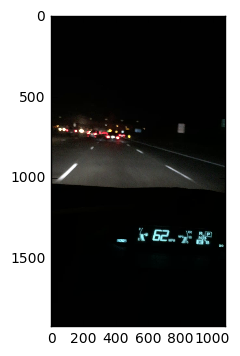

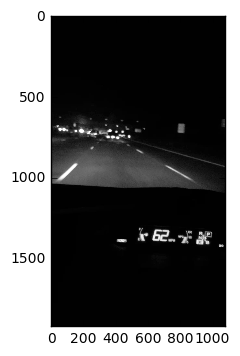

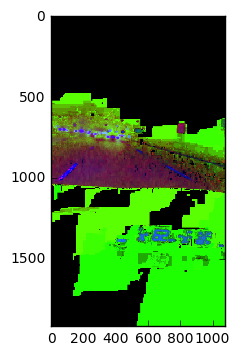

In [27]:
#get single image from night video



def foo(image):
    plt.figure(1)
    plt.imshow(image)
    gray = grayscale(image)
    plt.figure(2)
    plt.imshow(gray,cmap='Greys_r')
    canny_img = canny(gray,10,50)
    plt.figure(3)
    plt.imshow(canny_img,cmap='Greys_r')
    hsv_image = hsv(image)
    plt.imshow(hsv_image,cmap='hsv_r')

clip2 = VideoFileClip('night.m4v')
challenge_clip = clip2.fl_image(foo)





In [13]:
challenge_output = 'night_output.mp4'
clip2 = VideoFileClip('night.m4v')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

y_height 1920  x_width: 1080
[MoviePy] >>>> Building video night_output.mp4
[MoviePy] Writing video night_output.mp4



  1%|          | 2/260 [00:00<00:15, 16.91it/s]

y_height 1920  x_width: 1080
y_height 1920  x_width: 1080
y_height 1920  x_width: 1080



  2%|▏         | 4/260 [00:00<00:14, 17.48it/s]

y_height 1920  x_width: 1080



  2%|▏         | 6/260 [00:00<00:14, 17.02it/s]

y_height 1920  x_width: 1080
y_height 1920  x_width: 1080
y_height 1920  x_width: 1080


IndexError: list index out of range


  2%|▏         | 6/260 [00:16<11:35,  2.74s/it]

AttributeError: 'NoneType' object has no attribute 'shape'

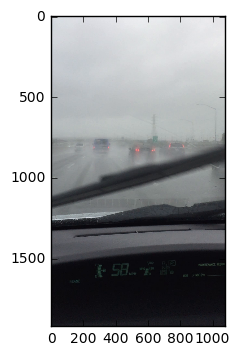

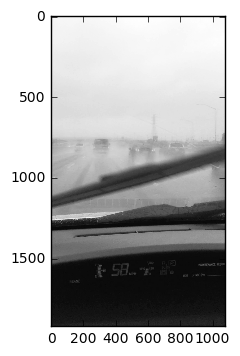

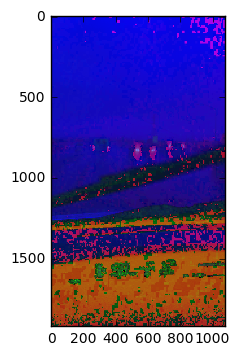

In [29]:


def rain_process(image):
    plt.figure(1)
    plt.imshow(image)
    gray = grayscale(image)
    plt.figure(2)
    plt.imshow(gray,cmap='Greys_r')
    canny_img = canny(gray,10,50)
    plt.figure(3)
    plt.imshow(canny_img,cmap='Greys_r')
    hsv_image = hsv(image)
    plt.imshow(hsv_image,cmap='hsv_r')




challenge_output = 'rain_output.mp4'
clip2 = VideoFileClip('rain.m4v')
challenge_clip = clip2.fl_image(rain_process)
%time challenge_clip.write_videofile(challenge_output, audio=False)

height: 1920  width: 1080


AttributeError: 'NoneType' object has no attribute 'shape'

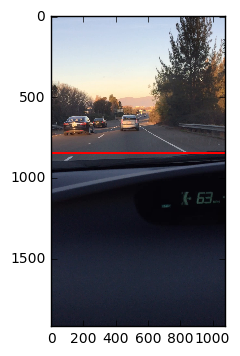

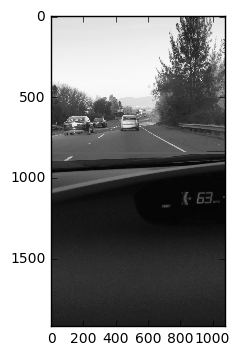

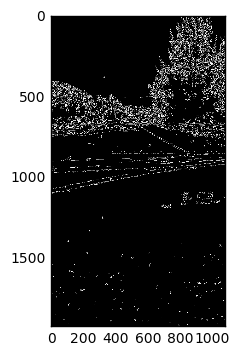

In [34]:
def freeway_merge(image):
    height = image.shape[0]
    width = image.shape[1]
    print("height:",height," width:",width)
    plt.figure(1)
    cv2.line(image,(0,850),(1080,850),(255,0,0),10)
    cv2.line(image,(),(),(255,0,0),10)
    
    plt.imshow(image)
    gray = grayscale(image)
    plt.figure(2)
    plt.imshow(gray,cmap='Greys_r')
    canny_img = canny(gray,10,50)
    plt.figure(3)
    plt.imshow(canny_img,cmap='Greys_r')
    



challenge_output = 'freeway_merge_output.mp4'
clip2 = VideoFileClip('freeway_merge.m4v')
challenge_clip = clip2.fl_image(freeway_merge)
%time challenge_clip.write_videofile(challenge_output, audio=False)